In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats

In [154]:
from sklearn.model_selection import train_test_split
# import sklearn.model_selection.train_test_split as train_test_split

import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
# sklearn - scikit learn

In [155]:
cars= pd.read_csv("C:\Alabs\Datasets\Car_sales - 1656244153716.csv", sep= "," )

In [156]:
cars.head()

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [157]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [158]:
cars.nunique()

Manufacturer               30
Model                     156
Sales_in_thousands        157
four_year_resale_value    117
Vehicle_type                2
Price_in_thousands        152
Engine_size                31
Horsepower                 66
Wheelbase                  88
Width                      78
Length                    127
Curb_weight               147
Fuel_capacity              55
Fuel_efficiency            20
Latest_Launch             130
Power_perf_factor         154
dtype: int64

In [159]:
cars_cat_var = cars.select_dtypes('object').columns
cars_con_var = cars.select_dtypes('float64').columns

In [160]:
cars_cat_var = cars_cat_var.drop(labels= 'Latest_Launch')

In [161]:
cars_cat_var

Index(['Manufacturer', 'Model', 'Vehicle_type'], dtype='object')

In [162]:
def fn_desc( x ):
    # missing values calculation
    ntot = x.shape[0]
    n = x.count()
    n_miss = ntot - n
    n_miss_perc = n_miss/ntot
    
    # get the lc and uc using IQR
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    IQR = q3 - q1
    lc_iqr = q1 - 1.5 * IQR
    uc_iqr = q3 + 1.5 * IQR
    
    # return the descriptives
    
    return pd.Series([x.dtype, x.nunique(),
                       ntot, n, n_miss, n_miss_perc,
                      IQR, lc_iqr, uc_iqr,
                      x.sum(), x.mean(), x.var(), x.std(),
                      x.min(), 
                      x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                      x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                      x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), 
                      x.max() ],
                     index = ['dtype', 'cardinality',
                               'ntot', 'n', 'n_miss', 'n_miss_perc',
                              'IQR', 'lc_iqr', 'uc_iqr',
                              'sum', 'mean', 'var', 'std',
                              'min', 
                              'p1', 'p5', 'p10', 
                              'p25', 'p50', 'p75', 
                              'p90', 'p95', 'p99',
                              'max' ])

In [163]:
cars.loc[:, cars_con_var].apply(fn_desc)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,157,117,152,31,66,88,78,127,147,55,20,154
ntot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
n_miss,0,36,2,1,1,1,1,1,2,1,3,2
n_miss_perc,0.0,0.229299,0.012739,0.006369,0.006369,0.006369,0.006369,0.006369,0.012739,0.006369,0.019108,0.012739
IQR,53.842,8.615,13.93,1.275,65.5,9.2,5.025,18.55,0.8285,3.775,5.0,29.007171
lc_iqr,-66.649,-1.6625,-2.8775,0.3875,51.25,89.2,60.8625,149.75,1.72825,10.1375,13.5,16.896951
uc_iqr,148.719,32.7975,52.8425,5.4875,313.25,126.0,80.9625,223.95,5.04225,25.2375,33.5,132.925634
sum,8320.698,2186.83,4245.567,477.5,29008.0,16768.0,11099.4,29225.6,523.594,2800.5,3672.0,11941.756636


In [164]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [165]:
cars.loc[:, cars_cat_var].apply(categorical_var_summary)

,Manufacturer,Model,Vehicle_type
N,157,157,157
NMISS,0,0,0
MODE,Dodge,Neon,Passenger
FREQ,11,2,116
PERCENT,7.01,1.27,73.89


In [166]:
#Outlier treatment
cars.loc[:, cars_con_var].apply( lambda x: x.clip (lower= x.quantile(0.01),upper= x.quantile(0.99)) )

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,16.919,16.360,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,39.384,19.875,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778
2,14.114,18.225,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,NaN
3,8.588,29.725,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779
4,20.397,22.255,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...
152,3.545,NaN,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,66.498812
153,15.245,NaN,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,70.654495
154,17.531,NaN,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,71.155978
155,3.493,NaN,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,101.623357


In [167]:
cars_cont = cars.loc[:, cars_con_var].apply( lambda x: x.clip (lower= x.quantile(0.01),upper= x.quantile(0.99)) )

In [168]:
cars_cont

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,16.919,16.360,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,39.384,19.875,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778
2,14.114,18.225,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,NaN
3,8.588,29.725,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779
4,20.397,22.255,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...
152,3.545,NaN,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,66.498812
153,15.245,NaN,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,70.654495
154,17.531,NaN,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,71.155978
155,3.493,NaN,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,101.623357


In [174]:
cars_cat = cars.loc[:, 'Vehicle_type']
cars_cat

0      Passenger
1      Passenger
2      Passenger
3      Passenger
4      Passenger
         ...    
152    Passenger
153    Passenger
154    Passenger
155    Passenger
156    Passenger
Name: Vehicle_type, Length: 157, dtype: object

In [178]:
cars_cat = pd.get_dummies( cars_cat, drop_first= True, dtype= 'int' )

In [179]:
# combining Categorical and Continuous vars DF
cars_new = pd.concat([cars_cat, cars_cont, ], axis = 1, verify_integrity= True )

<Axes: ylabel='Density'>

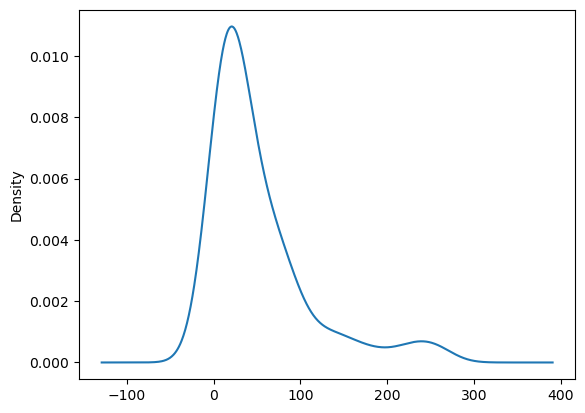

In [180]:
cars_new.loc[:, 'Sales_in_thousands'].plot(kind= 'kde')

In [181]:
cars_new.loc[:, 'Sales_in_thousands'].skew()

1.9924932920508793

In [182]:
cars_new.loc[:, 'log_sales'] = np.log(cars.loc[:, 'Sales_in_thousands'])

<Axes: ylabel='Density'>

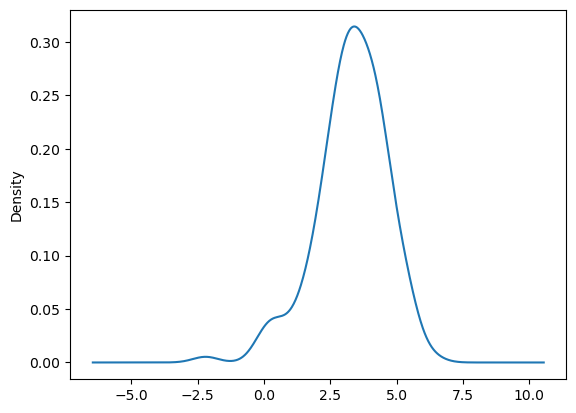

In [183]:
cars_new.loc[:, 'log_sales'].plot(kind= 'kde')

In [184]:
cars_new.loc[:, 'log_sales'].skew()

-0.8205758917073411

In [185]:
x_var = cars_new.columns.difference( ['log_sales', 'Sales_in_thousands' ] )
y_var = 'log_sales'

In [192]:
cars_new.corr()

,Passenger,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor,log_sales
Passenger,1.000000,-0.230252,0.088803,0.042440,-0.281839,-0.012019,-0.386606,-0.243692,-0.130893,-0.524764,-0.600226,0.604915,-0.003710,-0.273500
Sales_in_thousands,-0.230252,1.000000,-0.327201,-0.362054,-0.014342,-0.259313,0.278281,0.093054,0.200998,-0.035325,0.044446,0.036731,-0.285633,0.787511
four_year_resale_value,0.088803,-0.327201,1.000000,0.956165,0.508590,0.763531,-0.041390,0.177372,0.028542,0.369320,0.338989,-0.413708,0.824048,-0.525921
Price_in_thousands,0.042440,-0.362054,0.956165,1.000000,0.618276,0.851413,0.118082,0.328137,0.158226,0.529839,0.430996,-0.506784,0.906767,-0.552642
Engine_size,-0.281839,-0.014342,0.508590,0.618276,1.000000,0.815010,0.518423,0.702618,0.576386,0.800434,0.698341,-0.757995,0.796940,-0.109640
Horsepower,-0.012019,-0.259313,0.763531,0.851413,0.815010,1.000000,0.325247,0.538115,0.420472,0.643878,0.526554,-0.611891,0.992727,-0.376287
Wheelbase,-0.386606,0.278281,-0.041390,0.118082,0.518423,0.325247,1.000000,0.681402,0.837566,0.658013,0.659706,-0.500329,0.288762,0.286250
Width,-0.243692,0.093054,0.177372,0.328137,0.702618,0.538115,0.681402,1.000000,0.700153,0.713552,0.648557,-0.588345,0.506697,0.040961
Length,-0.130893,0.200998,0.028542,0.158226,0.576386,0.420472,0.837566,0.700153,1.000000,0.624995,0.561884,-0.422184,0.371103,0.212756
Curb_weight,-0.524764,-0.035325,0.369320,0.529839,0.800434,0.643878,0.658013,0.713552,0.624995,1.000000,0.868190,-0.830354,0.635687,-0.040312


### significance: F_Regression

In [193]:
# feature selection based on importance
from sklearn.feature_selection import f_regression

In [197]:
f_regression(X = cars.loc[:, x_var], y = y_var)

KeyError: "['Passenger'] not in index"

In [ ]:
f_val, p_val = f_regression(X = cars.loc[:, x_vars], y = cars.log_Sales_in_thousands)

In [ ]:
f_reg = pd.DataFrame(data = [x_vars, f_val, p_val] ).T
f_reg.columns = ['Features', 'F_Value', 'P_Value']

In [ ]:
f_reg

In [ ]:
f_reg.loc[f_reg.P_Value < 0.05]

In [ ]:
f_reg.loc[f_reg.P_Value < 0.10, 'Features']

In [ ]:
features = list(f_reg.loc[f_reg.P_Value < 0.10, 'Features'])

In [ ]:
'log_Sales_in_thousands~'+ '+'.join(features)

In [ ]:
formula_m2 = 'log_Sales_in_thousands~'+ '+'.join(features)
formula_m2

## Multicollinearity : VIF

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

y, X = dmatrices(formula_m2, data=cars, return_type="dataframe")


vif_factor = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [ ]:
vif_factor

In [ ]:
vif = pd.DataFrame()

In [ ]:
vif['features'] =  X.columns
vif

In [ ]:
[variance_inflation_factor(x.values, i) for i in range(X.shape[1])]

In [ ]:
vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
vif

In [ ]:
vif = vif.round(1).sort_values(by = 'VIF_Factor', ascending= False)
vif[vif.VIF_Factor < 4]

In [ ]:
vif = vif.loc[vif.VIF_Factor < 10]

In [ ]:
features = list(vif.loc[vif.VIF_Factor < 10, 'features'])

In [ ]:
'log_Sales_in_thousands ~' + '+'.join(features)

### removal of multicolinear variables (one at a time and running codes starting from VIF steps again to check changes in VIF)

### VIF factor should not be more than 5 for the x variables

In [ ]:
'''log_Sales_in_thousands ~Wheelbase+Manufacturer_Porsche+Manufacturer_MercedesB+Model_Carrera_Coupe
+Model_Carrera_Cabrio+Vehicle_type_Passenger+Model_Viper+Model_Prowler
+Model_A8+Manufacturer_Audi+Manufacturer_Ford+Model_CL500+
Manufacturer_Plymouth+Model_SLClass+Model_Ram_Pickup+Manufacturer_Honda+
Model_FSeries+Model_Accord+Manufacturer_Toyota+Model_GS400+Model_Ranger+
Model_SLK230+Model_Taurus+Model_Camry+Model_Explorer+Model_3000GT+
Manufacturer_Volvo+Model_Cutlass'''